In [1]:
# import time
import torch
# import os
import pandas as pd
import numpy as np
import models
from config import opt
import data
from sklearn import metrics
from tqdm.notebook import tqdm
# import visdom
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
from sklearn.metrics import confusion_matrix

def train_and_evaluate(model_name, model_class, save_model_path=None):
    opt.model = model_name
    opt._parse({})  # Reset the configuration for each model
    adj, features, labels, idx_train, idx_val, idx_test, edges, classes_dict = data.load_data(opt)
    train = data.Dataload(labels, idx_train)
    val = data.Dataload(labels, idx_val)
    test = data.Dataload(labels, idx_test)

    if model_name == 'PyGCN':
        model = getattr(models, opt.model)(features.shape[1], 128, max(labels) + 1).train()
    elif model_name == 'PyGAT':
        model = getattr(models, opt.model)(features.shape[1], 8, max(labels) + 1, dropout=0.6, alpha=0.2, nheads=8).train()
    elif model_name == 'PyGraphsage':
        model = getattr(models, opt.model)(features.shape[1], 8, max(labels) + 1)
    else:
        print("Please input the correct model name: PyGCN, PyGAT or PyGraphsage")
        return
    if opt.load_model_path:
        model.load(opt.load_model_path)

    model = model.to(opt.device)
    adj = adj.to(opt.device)
    features = features.to(opt.device)

    train_dataloader = DataLoader(train, opt.batch_size, shuffle=True, num_workers=opt.num_workers)
    val_dataloader = DataLoader(val, opt.batch_size, shuffle=True, num_workers=opt.num_workers)
    test_dataloader = DataLoader(test, opt.batch_size, shuffle=True, num_workers=opt.num_workers)

    criterion = torch.nn.CrossEntropyLoss()  # Use CrossEntropyLoss
    optimizer = torch.optim.AdamW(model.parameters(), lr=opt.lr, weight_decay=opt.weight_decay)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Example scheduler

    train_losses = []
    val_losses = []
    val_accuracies = []
    confusion_matrices = []

    for name, param in model.named_parameters():
        print(f"Parameter name: {name}, Parameter shape: {param.shape}")
        
    for epoch in range(opt.max_epoch):
        train_loss = 0
        model.train()

        for trains, labels in tqdm(train_dataloader, leave=False):
            labels = labels.to(opt.device)
            trains = trains.to(opt.device)
            optimizer.zero_grad()
            outputs = model(features, adj)
            loss = criterion(outputs[trains], labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_dataloader))

        lr_scheduler.step()  # Adjust learning rate

        val_loss, val_accuracy, labels_all, predict_all, conf_matrix = evaluate(opt, model, val_dataloader, epoch, features, adj)
        val_losses.append(val_loss)  # Store validation loss
        val_accuracies.append(val_accuracy)
        confusion_matrices.append(conf_matrix)

    print(confusion_matrices[-1])  # Print the last confusion matrix

    test_loss, test_accuracy, test_labels_all, test_predict_all, test_conf_matrix = evaluate(opt, model, test_dataloader, epoch, features, adj)
    if save_model_path:
        torch.save(model.state_dict(), save_model_path)

    return train_losses, val_losses, val_accuracies, confusion_matrices, test_loss, test_accuracy, test_labels_all, test_predict_all, test_conf_matrix

def evaluate(opt, model, val_dataloader, epoch, features, adj):
    model.eval()
    loss_total = 0
    predict_all = []
    labels_all = []
    criterion = torch.nn.CrossEntropyLoss()

    with torch.no_grad():
        for evals, labels in tqdm(val_dataloader):
            labels = labels.to(opt.device)
            evals = evals.to(opt.device)
            outputs = model(features, adj)
            loss = criterion(outputs[evals], labels)
            loss_total += loss.item()

            labels = labels.data.cpu().numpy()
            predictions = torch.max(outputs[evals].data, 1)[1].cpu().numpy()

            labels_all.extend(labels)
            predict_all.extend(predictions)

    accuracy = metrics.accuracy_score(labels_all, predict_all)
    print(f"Epoch {epoch}: Validation Loss: {loss_total}, Accuracy: {accuracy}")

    conf_matrix = confusion_matrix(labels_all, predict_all)

    return loss_total, accuracy, labels_all, predict_all, conf_matrix


user config:
model PyGCN
use_gpu False
device cpu
load_model_path None
network RO
batch_size 8
num_workers 3
max_epoch 10
lr 0.005
lr_decay 0.9
weight_decay 1e-05
train_rate 0.8
val_rate 0.1
dropout 0.5
Loading RO dataset...
Parameter name: gc1.weight, Parameter shape: torch.Size([84, 128])
Parameter name: gc1.bias, Parameter shape: torch.Size([128])
Parameter name: gc2.weight, Parameter shape: torch.Size([128, 68])
Parameter name: gc2.bias, Parameter shape: torch.Size([68])


  0%|          | 0/4178 [00:00<?, ?it/s]

  0%|          | 0/523 [00:00<?, ?it/s]

Epoch 0: Validation Loss: 974.8349353075027, Accuracy: 0.45774479291357434


  0%|          | 0/4178 [00:00<?, ?it/s]

  0%|          | 0/523 [00:00<?, ?it/s]

Epoch 1: Validation Loss: 856.8830537199974, Accuracy: 0.5063442662197749


  0%|          | 0/4178 [00:00<?, ?it/s]

  0%|          | 0/523 [00:00<?, ?it/s]

Epoch 2: Validation Loss: 782.285887748003, Accuracy: 0.5348336126406512


  0%|          | 0/4178 [00:00<?, ?it/s]

  0%|          | 0/523 [00:00<?, ?it/s]

Epoch 3: Validation Loss: 736.3905470073223, Accuracy: 0.5523102705290879


  0%|          | 0/4178 [00:00<?, ?it/s]

  0%|          | 0/523 [00:00<?, ?it/s]

Epoch 4: Validation Loss: 703.6056469976902, Accuracy: 0.5738568350490783


  0%|          | 0/4178 [00:00<?, ?it/s]

  0%|          | 0/523 [00:00<?, ?it/s]

Epoch 5: Validation Loss: 677.4942403435707, Accuracy: 0.5748144601388556


  0%|          | 0/4178 [00:00<?, ?it/s]

  0%|          | 0/523 [00:00<?, ?it/s]

Epoch 6: Validation Loss: 664.9659887552261, Accuracy: 0.5755326789561886


  0%|          | 0/4178 [00:00<?, ?it/s]

  0%|          | 0/523 [00:00<?, ?it/s]

Epoch 7: Validation Loss: 641.3314552903175, Accuracy: 0.5812784294948528


  0%|          | 0/4178 [00:00<?, ?it/s]

  0%|          | 0/523 [00:00<?, ?it/s]

Epoch 8: Validation Loss: 634.4506278932095, Accuracy: 0.5879818051232942


  0%|          | 0/4178 [00:00<?, ?it/s]

  0%|          | 0/523 [00:00<?, ?it/s]

Epoch 9: Validation Loss: 623.3664423525333, Accuracy: 0.5889394302130716
[[37  0  0 ...  0  3  0]
 [ 0  5  0 ...  0  0  0]
 [ 0  0  1 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0 12  0]
 [ 0  0  0 ...  0  0  1]]


  0%|          | 0/523 [00:00<?, ?it/s]

Epoch 9: Validation Loss: 622.6185025274754, Accuracy: 0.5889394302130716
0.5889394302130716
user config:
model PyGraphsage
use_gpu False
device cpu
load_model_path None
network RO
batch_size 8
num_workers 3
max_epoch 10
lr 0.005
lr_decay 0.9
weight_decay 1e-05
train_rate 0.8
val_rate 0.1
dropout 0.5
Loading RO dataset...
Parameter name: sage1.W, Parameter shape: torch.Size([168, 8])
Parameter name: sage1.bias, Parameter shape: torch.Size([8])
Parameter name: sage2.W, Parameter shape: torch.Size([16, 8])
Parameter name: sage2.bias, Parameter shape: torch.Size([8])
Parameter name: att.weight, Parameter shape: torch.Size([68, 8])
Parameter name: att.bias, Parameter shape: torch.Size([68])


  0%|          | 0/4178 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  0%|          | 0/523 [00:00<?, ?it/s]

Epoch 0: Validation Loss: 553.54213229171, Accuracy: 0.7213310988747905


  0%|          | 0/4178 [00:00<?, ?it/s]

  0%|          | 0/523 [00:00<?, ?it/s]

Epoch 1: Validation Loss: 464.176971398294, Accuracy: 0.7713670098156572


  0%|          | 0/4178 [00:00<?, ?it/s]

  0%|          | 0/523 [00:00<?, ?it/s]

Epoch 2: Validation Loss: 438.17772836983204, Accuracy: 0.7840555422552071


  0%|          | 0/4178 [00:00<?, ?it/s]

  0%|          | 0/523 [00:00<?, ?it/s]

Epoch 3: Validation Loss: 417.05903080292046, Accuracy: 0.8029686377783098


  0%|          | 0/4178 [00:00<?, ?it/s]

  0%|          | 0/523 [00:00<?, ?it/s]

Epoch 4: Validation Loss: 404.1490837559104, Accuracy: 0.8084749820445296


  0%|          | 0/4178 [00:00<?, ?it/s]

  0%|          | 0/523 [00:00<?, ?it/s]

Epoch 5: Validation Loss: 393.0212045907974, Accuracy: 0.8072779506823079


  0%|          | 0/4178 [00:00<?, ?it/s]

  0%|          | 0/523 [00:00<?, ?it/s]

Epoch 6: Validation Loss: 393.0297397710383, Accuracy: 0.813023701220972


  0%|          | 0/4178 [00:00<?, ?it/s]

  0%|          | 0/523 [00:00<?, ?it/s]

Epoch 7: Validation Loss: 379.78263356536627, Accuracy: 0.8048838879578645


  0%|          | 0/4178 [00:00<?, ?it/s]

  0%|          | 0/523 [00:00<?, ?it/s]

Epoch 8: Validation Loss: 382.735201000236, Accuracy: 0.8082355757720853


  0%|          | 0/4178 [00:00<?, ?it/s]

  0%|          | 0/523 [00:00<?, ?it/s]

Epoch 9: Validation Loss: 366.3728342745453, Accuracy: 0.8202058893943022
[[63  0  0 ...  0  0  0]
 [ 0  4  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0 10  0]
 [ 0  0  0 ...  0  0  0]]


  0%|          | 0/523 [00:00<?, ?it/s]

Epoch 9: Validation Loss: 366.5802157733124, Accuracy: 0.8202058893943022
0.8202058893943022


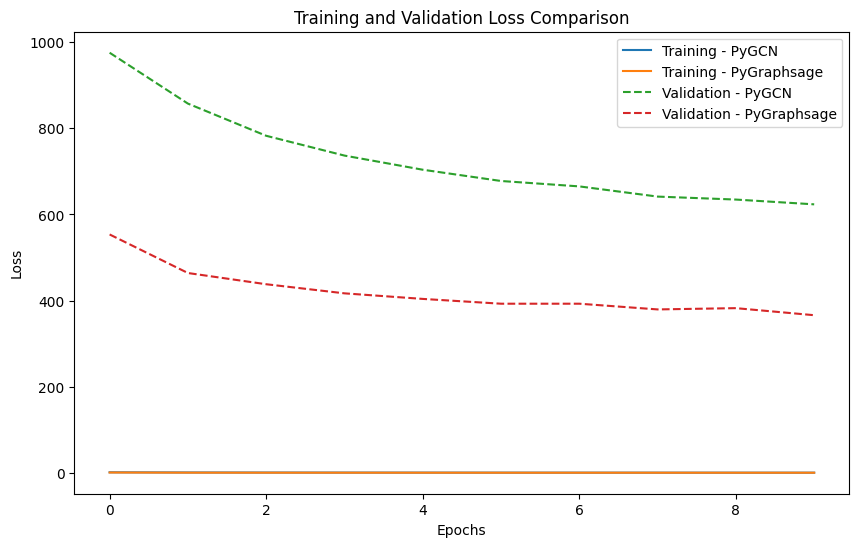

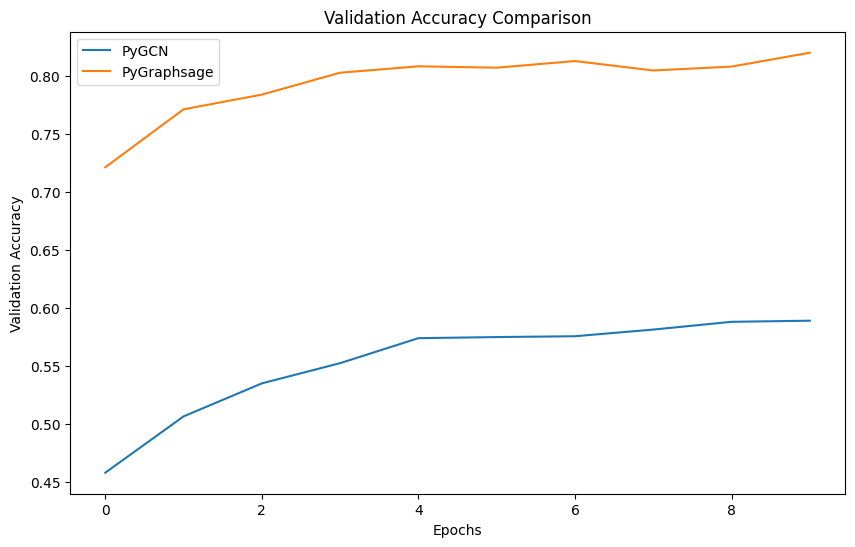

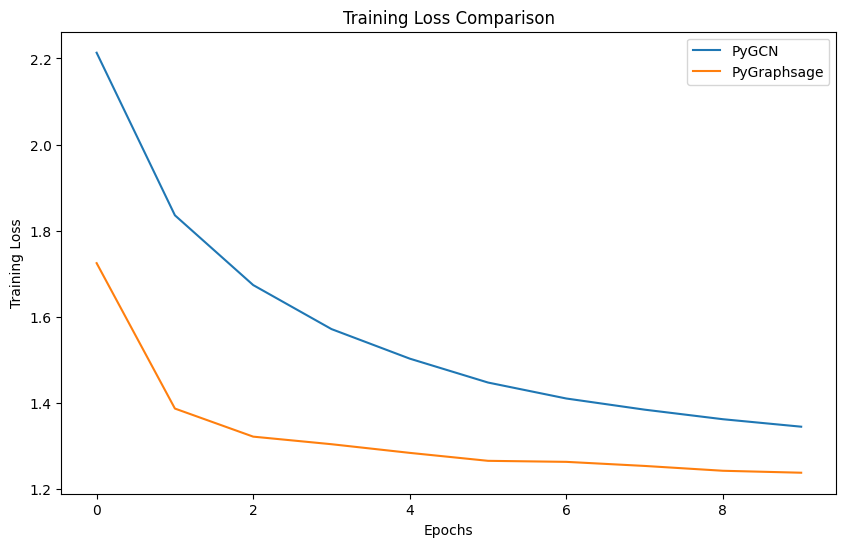

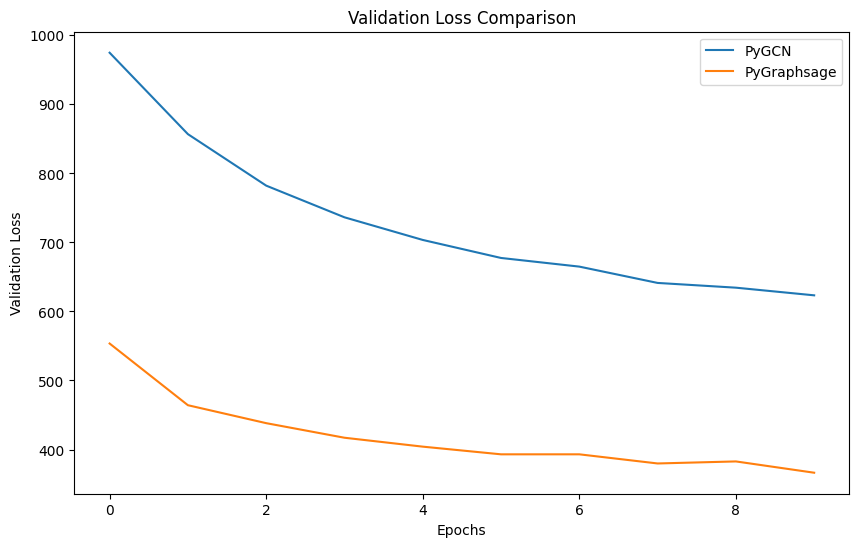

In [3]:
if __name__ == '__main__':
    opt.network = 'RO'  # SELECT HERE THE DATASET YOU WANT
    opt.train_rate = 0.8
    opt.val_rate = 0.1
    opt.max_epoch = 10
    model_names = ['PyGCN', 'PyGraphsage']
    model_classes = [models.PyGCN, models.Graphsage]

    # add the GAT
    # model_names = ['PyGraphsage']
    # model_classes = [models.PyGraphsage]

    train_loss_data = {}
    val_loss_data = {}  # Add this line to store validation losses
    val_accuracy_data = {}

    for model_name, model_class in zip(model_names, model_classes):
        save_path = f"{model_name}_model.pth"  # Specify the path where you want to save the model
        train_losses, val_losses, val_accuracies, conf_matrix,  test_loss, test_accuracy, test_labels_all, test_predict_all, test_conf_matrix = train_and_evaluate(model_name, model_class, save_model_path=save_path)
        train_loss_data[model_name] = train_losses
        val_loss_data[model_name] = val_losses  # Store validation losses
        val_accuracy_data[model_name] = val_accuracies
        print(test_accuracy)

        
     # Create line plots for training and validation losses
    plt.figure(figsize=(10, 6))
    
    # Plot training losses
    for model_name, train_losses in train_loss_data.items():
        plt.plot(train_losses, label=f'Training - {model_name}')
    
    # Plot validation losses
    for model_name, val_losses in val_loss_data.items():
        plt.plot(val_losses, label=f'Validation - {model_name}', linestyle='dashed')
    
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Comparison")
    plt.legend()
    plt.savefig("combined_loss_plot.png")
    plt.show()

    
    # Create line plots for validation accuracies
    plt.figure(figsize=(10, 6))
    for model_name, val_accuracies in val_accuracy_data.items():
        plt.plot(val_accuracies, label=model_name)
    plt.xlabel("Epochs")
    plt.ylabel("Validation Accuracy")
    plt.title("Validation Accuracy Comparison")
    plt.legend()
    plt.savefig("plot_val_acc.png")
    plt.show()

    # Create line plots for training losses
    plt.figure(figsize=(10, 6))
    for model_name, train_losses in train_loss_data.items():
        plt.plot(train_losses, label=model_name)
    plt.xlabel("Epochs")
    plt.ylabel("Training Loss")
    plt.title("Training Loss Comparison")
    plt.legend()
    plt.savefig("plot.png")5
    
    plt.show()

    # Create line plots for validation losses
    plt.figure(figsize=(10, 6))
    for model_name, val_losses in val_loss_data.items():
        plt.plot(val_losses, label=model_name)
    plt.xlabel("Epochs")
    plt.ylabel("Validation Loss")
    plt.title("Validation Loss Comparison")
    plt.legend()
    plt.savefig("plot_val_loss.png")
    plt.show()



In [4]:
### Node degree
adj, features, labels, idx_train, idx_val, idx_test, edges,classes_dict = data.load_data(opt)
node_degrees_dict = {}
print("Split", len(idx_train), len(idx_val), len(idx_test))
# Count the out-degrees for each node
for edge in edges:
    for node in edge:
        if node in node_degrees_dict:
            node_degrees_dict[node] += 1
        else:
            node_degrees_dict[node] = 1

# Print or use the dictionary
# print(f"""Node Degrees {opt.network}:""", node_degrees_dict)

Loading RO dataset...
Split 33418 4177 4177


In [5]:
classes_dict

{'R&B': 0,
 'Country': 1,
 'Alternative_Country': 2,
 'Chill_Out/Trip-Hop/Lounge': 3,
 'Film_Scores': 4,
 'Kids': 5,
 'Opera': 6,
 'Dance': 7,
 'Soundtracks': 8,
 'Disco': 9,
 'Kids_&_Family': 10,
 'Rap/Hip_Hop': 11,
 'Electro': 12,
 'Rock': 13,
 'Modern': 14,
 'Asian_Music': 15,
 'Electro_Hip_Hop': 16,
 'Hard_Rock': 17,
 'Bluegrass': 18,
 'Bolero': 19,
 'Trance': 20,
 'Rock_&_Roll/Rockabilly': 21,
 'Vocal_jazz': 22,
 'Alternative': 23,
 'Folk': 24,
 'Brazilian_Music': 25,
 'Musicals': 26,
 'East_Coast': 27,
 'International_Pop': 28,
 'Comedy': 29,
 'Indian_Music': 30,
 'Grime': 31,
 'Baroque': 32,
 'Classical_Period': 33,
 'Indie_Rock/Rock_pop': 34,
 'Country_Blues': 35,
 'Indie_Rock': 36,
 'Metal': 37,
 'Films/Games': 38,
 'Soul_&_Funk': 39,
 'Latin_Music': 40,
 'African_Music': 41,
 'Chicago_Blues': 42,
 'Dirty_South': 43,
 'Nursery_Rhymes': 44,
 'Singer_&_Songwriter': 45,
 'Contemporary_Soul': 46,
 'Pop': 47,
 'Sports': 48,
 'Jazz_Hip_Hop': 49,
 'Spirituality_&_Religion': 50,
 'Dub

In [6]:
test_conf_matrix

array([[63,  0,  0, ...,  0,  0,  0],
       [ 0,  4,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0, 10,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

In [7]:
test_accuracy

0.8202058893943022

In [8]:
train_loss_data

{'PyGCN': [2.213211657671109,
  1.8356555595587405,
  1.6736456329290978,
  1.5714343236487354,
  1.5027856005470739,
  1.4472844780932321,
  1.4102078731434375,
  1.3843262333399717,
  1.3621152901175833,
  1.3447549409875463],
 'PyGraphsage': [1.7245807635222057,
  1.3868603104963548,
  1.3216474811466703,
  1.3040696529305085,
  1.2839564536972343,
  1.2654900946803729,
  1.2630986478081612,
  1.253623884107049,
  1.2424121854034136,
  1.237863097612266]}

In [9]:
val_accuracy_data

{'PyGCN': [0.45774479291357434,
  0.5063442662197749,
  0.5348336126406512,
  0.5523102705290879,
  0.5738568350490783,
  0.5748144601388556,
  0.5755326789561886,
  0.5812784294948528,
  0.5879818051232942,
  0.5889394302130716],
 'PyGraphsage': [0.7213310988747905,
  0.7713670098156572,
  0.7840555422552071,
  0.8029686377783098,
  0.8084749820445296,
  0.8072779506823079,
  0.813023701220972,
  0.8048838879578645,
  0.8082355757720853,
  0.8202058893943022]}

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [26]:
# Sum of rows

class_labels = list(classes_dict.keys())
row_sums = np.sum(test_conf_matrix, axis=1)

# Sum of columns
column_sums = np.sum(test_conf_matrix, axis=0)
# Sum total
matrix_sum = np.sum(test_conf_matrix)


# print("Sum of rows:", row_sums/matrix_sum*100)
# print("Sum of columns:", column_sums/matrix_sum*100)

# Convert confusion matrix to percentages
cora_gcn_matrix_percentage = test_conf_matrix.astype('float') / test_conf_matrix.sum(axis=1)[:, np.newaxis] * 100


total_sum = np.sum(test_conf_matrix)

print(len(test_conf_matrix))
print(len(class_labels))
print(row_proportions)
print(class_labels)

# # Proportions
# row_proportions = row_sums / total_sum * 100
# column_proportions = column_sums / total_sum * 100

# # Pie chart for row proportions with actual values
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.pie(row_proportions, labels=class_labels, autopct='%1.1f%%')
# plt.title('Original values')

# # Pie chart for column proportions with predicted values
# plt.subplot(1, 2, 2)
# plt.pie(column_proportions, labels=class_labels, autopct='%1.1f%%')
# plt.title('Predicted values')

# plt.tight_layout()
# plt.show()


49
68
[ 2.75317213  0.21546565  0.02394063  1.29279387  0.76610007  0.43093129
 21.40292076  0.19152502  0.19152502 10.94086665  1.43643763  1.14915011
  0.04788125  0.04788125  0.31122815  0.93368446  0.02394063  0.02394063
  0.43093129  3.66291597  0.33516878  0.04788125  0.02394063  5.55422552
  0.5266938   0.02394063  0.02394063  0.14364376  5.91333493  0.76610007
  9.62413215  0.04788125  0.86186258  1.24491262  0.2633469  14.05314819
  0.23940627  0.07182188  4.93176921  0.28728753  0.07182188  0.14364376
  0.47881254  0.74215944  1.98707206  3.85444099  0.02394063  1.02944697
  0.40699066]
['R&B', 'Country', 'Alternative_Country', 'Chill_Out/Trip-Hop/Lounge', 'Film_Scores', 'Kids', 'Opera', 'Dance', 'Soundtracks', 'Disco', 'Kids_&_Family', 'Rap/Hip_Hop', 'Electro', 'Rock', 'Modern', 'Asian_Music', 'Electro_Hip_Hop', 'Hard_Rock', 'Bluegrass', 'Bolero', 'Trance', 'Rock_&_Roll/Rockabilly', 'Vocal_jazz', 'Alternative', 'Folk', 'Brazilian_Music', 'Musicals', 'East_Coast', 'Internatio

In [23]:
len(list(classes_dict.keys()))

68